<a href="https://colab.research.google.com/github/kaushikdhuli/flowerrecognition/blob/main/DinakaraKaushik_pytorch_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets --upgrade

**1.Dataset Selection:**

In [ ]:
import opendatasets as od
data= 'https://www.kaggle.com/datasets/alxmamaev/flowers-recognition'
od.download(data)

100%|██████████| 225M/225M [00:02<00:00, 79.7MB/s]


**2.Data preprocessing**





Skipping, found downloaded files in "./flowers-recognition" (use force=True to force download)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


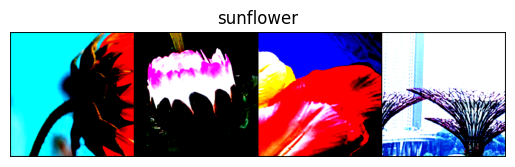

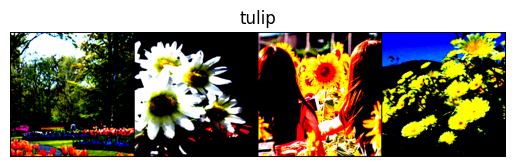

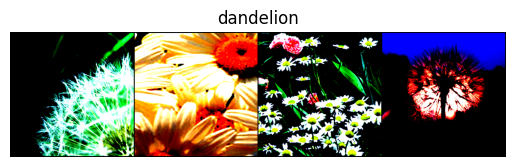

In [ ]:
import opendatasets as od
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import os

# Download and extract the dataset
data_url = 'https://www.kaggle.com/datasets/alxmamaev/flowers-recognition'
od.download(data_url)

# Define constants
RESIZE_DIM = 300
IMG_DIM = 256
BATCH_SIZE = 128
VALIDATION_FRACTION = 0.15
TEST_FRACTION = 0.2
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Define data transforms
TRAIN_TRANSFORMS = [
    T.Resize(RESIZE_DIM, interpolation=Image.BICUBIC),
    T.RandomResizedCrop(IMG_DIM),
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    T.ToTensor(),
    T.Normalize(mean=imagenet_stats[0], std=imagenet_stats[1])
]

VALIDATION_AND_TEST_TRANSFORMS = [
    T.Resize(RESIZE_DIM, interpolation=Image.BICUBIC),
    T.CenterCrop(IMG_DIM),
    T.ToTensor(),
    T.Normalize(mean=imagenet_stats[0], std=imagenet_stats[1])
]

# Define data directories
DATA_DIR = './flowers-recognition/flowers'

# Create datasets with transforms
flowers_data = ImageFolder(DATA_DIR, transform=T.Compose(TRAIN_TRANSFORMS))

# Calculate dataset sizes
num_data = len(flowers_data)
num_train = int((1 - VALIDATION_FRACTION - TEST_FRACTION) * num_data)
num_validation = int(VALIDATION_FRACTION * num_data)
num_test = int(TEST_FRACTION * num_data)

# Split the dataset into training, validation, and test sets
indices = np.random.permutation(num_data)
train_idx, validation_idx, test_idx = (
    indices[:num_train],
    indices[num_train:num_train + num_validation],
    indices[num_train + num_validation:]
)

# Create data samplers
train_sampler = SubsetRandomSampler(train_idx)
validation_sampler = SubsetRandomSampler(validation_idx)
test_sampler = SubsetRandomSampler(test_idx)

# Create data loaders with transforms
train_loader = DataLoader(flowers_data, batch_size=BATCH_SIZE, sampler=train_sampler,
                          num_workers=4, pin_memory=True, drop_last=True)
validation_loader = DataLoader(flowers_data, batch_size=BATCH_SIZE, sampler=validation_sampler,
                               num_workers=4, pin_memory=True, drop_last=True)
test_loader = DataLoader(flowers_data, batch_size=BATCH_SIZE, sampler=test_sampler,
                         num_workers=4, pin_memory=True, drop_last=True)

# Show a sample image and its class label
def show_sample(image, label):
    plt.imshow(image.permute(1, 2, 0))
    plt.title(flowers_data.classes[label])
    plt.axis('off')
    plt.show()

# Display a sample image from the training set
for images, labels in train_loader:
    show_sample(make_grid(images[:4]), labels[0])
    break

# Display a sample image from the validation set
for images, labels in validation_loader:
    show_sample(make_grid(images[:4]), labels[0])
    break

# Display a sample image from the test set
for images, labels in test_loader:
    show_sample(make_grid(images[:4]), labels[0])
    break


**3.Model Selection and Architecture**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 64 * 64, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Instantiate the model
model = SimpleCNN(num_classes=5)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop (you can customize this according to your needs)
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Training Loss: {running_loss / len(train_loader)}")

# Evaluate the model on the validation set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in validation_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = correct / total
print(f"Validation Accuracy: {accuracy}")


Epoch 1, Training Loss: 3.6827898763474964
Epoch 2, Training Loss: 1.4820637816474551
Epoch 3, Training Loss: 1.3679875646318709
Epoch 4, Training Loss: 1.3157234362193517
Epoch 5, Training Loss: 1.2739740439823695
Validation Accuracy: 0.4609375


**4.Model Training**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 64 * 64, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Instantiate the model
model = SimpleCNN(num_classes=5)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define early stopping parameters
patience = 3
min_delta = 0.01
best_val_loss = float('inf')
best_epoch = 0
no_improvement_count = 0

# Training loop with early stopping
num_epochs = 20  # Increase if needed
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Calculate validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in validation_loader:
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()

    # Update early stopping criteria
    val_loss /= len(validation_loader)
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        best_epoch = epoch
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    print(f"Epoch {epoch+1}, Training Loss: {running_loss / len(train_loader)}, Validation Loss: {val_loss}")

    # Early stopping check
    if no_improvement_count >= patience:
        print(f"Early stopping at epoch {epoch+1}...")
        break

# Evaluate the model on the test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy}")


Epoch 1, Training Loss: 5.013849161920094, Validation Loss: 1.507819151878357
Epoch 2, Training Loss: 1.4886991012664068, Validation Loss: 1.4899992227554322
Epoch 3, Training Loss: 1.4718292781284876, Validation Loss: 1.429684329032898
Epoch 4, Training Loss: 1.4138755344209217, Validation Loss: 1.3336865186691285
Epoch 5, Training Loss: 1.3609797727494013, Validation Loss: 1.330044150352478
Epoch 6, Training Loss: 1.3260524272918701, Validation Loss: 1.2960121393203736
Epoch 7, Training Loss: 1.2883038293747675, Validation Loss: 1.2406116485595704
Epoch 8, Training Loss: 1.2353820006052654, Validation Loss: 1.199412178993225
Epoch 9, Training Loss: 1.2179688328788394, Validation Loss: 1.1783023834228517
Epoch 10, Training Loss: 1.1835351444426037, Validation Loss: 1.1232968330383302
Epoch 11, Training Loss: 1.1463707799003238, Validation Loss: 1.106807780265808
Epoch 12, Training Loss: 1.128132198538099, Validation Loss: 1.102075171470642
Epoch 13, Training Loss: 1.1254995862642925, 

In [ ]:
import torch
import os
# Define the directory where you want to save the model weights
save_dir = './saved_models'
os.makedirs(save_dir, exist_ok=True)

# Specify the filename for your model weights
filename = 'simple_cnn_model.pth'
filepath = os.path.join(save_dir, filename)

# Save the model weights
torch.save(model.state_dict(), filepath)

**5.Hyperparameter Tuning:**

In [ ]:
import pandas as pd

# Define a function for training the model with given hyperparameters
def train_model(model, criterion, optimizer, train_loader, validation_loader, num_epochs=10, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)  # Update optimizer with the specified learning rate
    history = {'epoch': [], 'train_loss': [], 'val_loss': [], 'val_accuracy': []}

    patience = 3
    min_delta = 0.01
    best_val_loss = float('inf')
    best_epoch = 0
    no_improvement_count = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Calculate validation loss and accuracy
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in validation_loader:
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_loss /= len(validation_loader)
        val_accuracy = correct / total

        # Update early stopping criteria
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            best_epoch = epoch
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        print(f"Epoch {epoch+1}, Training Loss: {running_loss / len(train_loader)}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

        # Early stopping check
        if no_improvement_count >= patience:
            print(f"Early stopping at epoch {epoch+1}...")
            break

        # Store history
        history['epoch'].append(epoch)
        history['train_loss'].append(running_loss / len(train_loader))
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)

    return model, history

# Hyperparameter tuning
hyperparameters = {
    'learning_rates': [0.01, 0.001],
    'batch_sizes': [16, 32]
}

results = []

for lr in hyperparameters['learning_rates']:
    for batch_size in hyperparameters['batch_sizes']:
        print(f"\nTraining with LR: {lr}, Batch Size: {batch_size}")

        model = SimpleCNN(num_classes=5)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        train_loader = DataLoader(flowers_data, batch_size=batch_size, sampler=train_sampler,
                                  num_workers=4, pin_memory=True, drop_last=True)
        validation_loader = DataLoader(flowers_data, batch_size=batch_size, sampler=validation_sampler,
                                       num_workers=4, pin_memory=True, drop_last=True)

        trained_model, history = train_model(model, criterion, optimizer, train_loader, validation_loader)

        # After the training loop
        test_correct = 0
        test_total = 0
        with torch.no_grad():
          for images, labels in test_loader:
            outputs = trained_model(images)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

        test_accuracy = test_correct / test_total
        print(f"Test Accuracy with LR: {lr}, Batch Size: {batch_size}: {test_accuracy}")
        results.append({'LR': lr, 'Batch Size': batch_size, 'Test Accuracy': test_accuracy})

        results.append({'LR': lr, 'Batch Size': batch_size, 'Test Accuracy': test_accuracy})
        print(f"Test Accuracy with LR: {lr}, Batch Size: {batch_size}: {test_accuracy}")

        # Convert results to DataFrame for easier analysis and visualization
        results_df = pd.DataFrame(results)
        print(results_df)



Training with LR: 0.01, Batch Size: 16
Epoch 1, Training Loss: 1.9359470169884818, Validation Loss: 1.4530355483293533, Validation Accuracy: 0.39375
Epoch 2, Training Loss: 1.382281712463924, Validation Loss: 1.3515071243047714, Validation Accuracy: 0.4140625
Epoch 3, Training Loss: 1.301772688456944, Validation Loss: 1.3222584128379822, Validation Accuracy: 0.45625
Epoch 4, Training Loss: 1.2508373975753784, Validation Loss: 1.2430537566542625, Validation Accuracy: 0.475
Epoch 5, Training Loss: 1.210241848060063, Validation Loss: 1.1861228436231612, Validation Accuracy: 0.50625
Epoch 6, Training Loss: 1.203412434373583, Validation Loss: 1.1377721533179284, Validation Accuracy: 0.5328125
Epoch 7, Training Loss: 1.1581701404707772, Validation Loss: 1.229098641872406, Validation Accuracy: 0.534375
Epoch 8, Training Loss: 1.145856442110879, Validation Loss: 1.1196919143199922, Validation Accuracy: 0.5671875
Epoch 9, Training Loss: 1.120817941938128, Validation Loss: 1.0643875747919083, V

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 1, Training Loss: 3.159102982488172, Validation Loss: 1.5734184443950654, Validation Accuracy: 0.2515625
Epoch 2, Training Loss: 1.5465935317949318, Validation Loss: 1.4273799061775208, Validation Accuracy: 0.35625
Epoch 3, Training Loss: 1.4026323365068984, Validation Loss: 1.3091556251049041, Validation Accuracy: 0.4421875
Epoch 4, Training Loss: 1.320610064199601, Validation Loss: 1.2612616062164306, Validation Accuracy: 0.50625
Epoch 5, Training Loss: 1.252640002760394, Validation Loss: 1.2037102580070496, Validation Accuracy: 0.5
Epoch 6, Training Loss: 1.1857072697288689, Validation Loss: 1.1315224826335908, Validation Accuracy: 0.5625
Epoch 7, Training Loss: 1.1587374662530834, Validation Loss: 1.0627128422260284, Validation Accuracy: 0.5875
Epoch 8, Training Loss: 1.1213908284560017, Validation Loss: 1.0925624400377274, Validation Accuracy: 0.571875
Epoch 9, Training Loss: 1.0956732986987323, Validation Loss: 1.0397427797317504, Validation Accuracy: 0.5921875
Epoch 10, Tr

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 1, Training Loss: 2.039803395952497, Validation Loss: 1.3824286699295043, Validation Accuracy: 0.4109375
Epoch 2, Training Loss: 1.3484547867093768, Validation Loss: 1.318639062345028, Validation Accuracy: 0.4578125
Epoch 3, Training Loss: 1.2930196302277701, Validation Loss: 1.2334329694509507, Validation Accuracy: 0.4765625
Epoch 4, Training Loss: 1.250871138572693, Validation Loss: 1.2779087290167808, Validation Accuracy: 0.440625
Epoch 5, Training Loss: 1.1973886152676174, Validation Loss: 1.1635395362973213, Validation Accuracy: 0.54375
Epoch 6, Training Loss: 1.1843804713657924, Validation Loss: 1.1679987639188767, Validation Accuracy: 0.5046875
Epoch 7, Training Loss: 1.1640772952352252, Validation Loss: 1.1169089302420616, Validation Accuracy: 0.55625
Epoch 8, Training Loss: 1.1305505415371486, Validation Loss: 1.1220956102013588, Validation Accuracy: 0.534375
Epoch 9, Training Loss: 1.0948576831817627, Validation Loss: 1.0325509816408158, Validation Accuracy: 0.584375
Ep

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 1, Training Loss: 2.3873224244720634, Validation Loss: 1.4986659348011018, Validation Accuracy: 0.3296875
Epoch 2, Training Loss: 1.4151688868972077, Validation Loss: 1.3539460718631744, Validation Accuracy: 0.434375
Epoch 3, Training Loss: 1.3359913209388996, Validation Loss: 1.2901110231876374, Validation Accuracy: 0.4546875
Epoch 4, Training Loss: 1.2786405744223759, Validation Loss: 1.1818166345357894, Validation Accuracy: 0.521875
Epoch 5, Training Loss: 1.2059615617510917, Validation Loss: 1.101102077960968, Validation Accuracy: 0.5421875
Epoch 6, Training Loss: 1.1427260911327668, Validation Loss: 1.0977388054132462, Validation Accuracy: 0.5515625
Epoch 7, Training Loss: 1.1154667324033276, Validation Loss: 1.111650103330612, Validation Accuracy: 0.5234375
Epoch 8, Training Loss: 1.1071309036221997, Validation Loss: 1.1050259560346603, Validation Accuracy: 0.5484375
Early stopping at epoch 8...
Test Accuracy with LR: 0.001, Batch Size: 32: 0.5807291666666666
Test Accuracy 

**6.Evaluation:**

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation Accuracy: 0.575
Validation Precision: 0.5781363808987927
Validation Recall: 0.575
Validation F1-score: 0.5725146840457185
Confusion Matrix:
[[ 60  17   6   5   7]
 [ 15 111   5  29   9]
 [ 16   7  43   6  45]
 [  5  13   5  72  26]
 [ 13  16  24   3  82]]


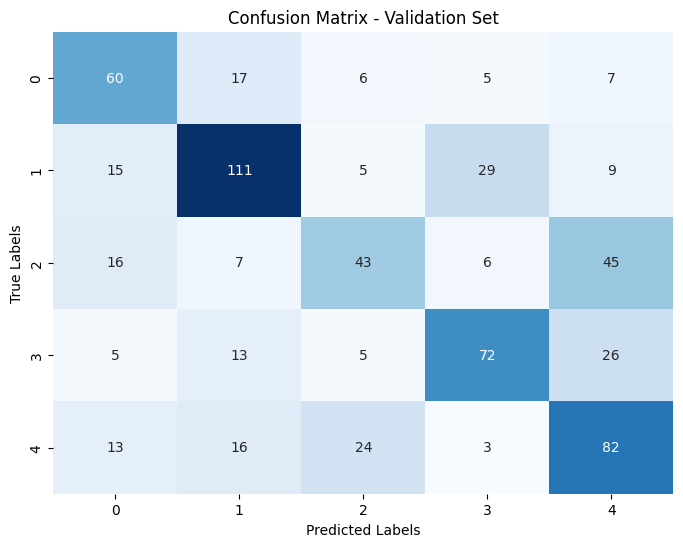

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


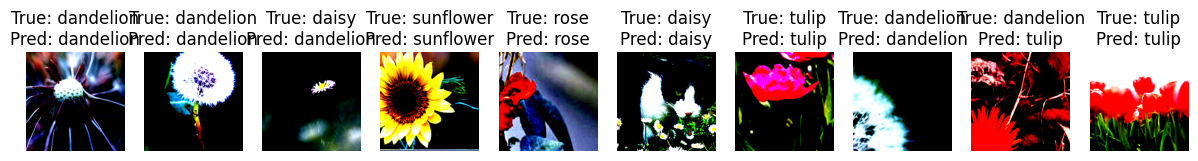

In [ ]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Define a function to evaluate the model on the validation set and calculate metrics
def evaluate_model(model, validation_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in validation_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.tolist())
            y_pred.extend(predicted.tolist())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    confusion_mat = confusion_matrix(y_true, y_pred)

    return accuracy, precision, recall, f1, confusion_mat

# Evaluate the trained model on the validation set
accuracy_val, precision_val, recall_val, f1_val, confusion_mat_val = evaluate_model(model, validation_loader)

print(f"Validation Accuracy: {accuracy_val}")
print(f"Validation Precision: {precision_val}")
print(f"Validation Recall: {recall_val}")
print(f"Validation F1-score: {f1_val}")
print("Confusion Matrix:")
print(confusion_mat_val)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat_val, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Validation Set')
plt.show()

# Visualize model predictions and misclassifications
def visualize_predictions(model, validation_loader, num_images=10):
    model.eval()
    with torch.no_grad():
        for images, labels in validation_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
            for i in range(num_images):
                axs[i].imshow(images[i].permute(1, 2, 0))
                axs[i].set_title(f"True: {flowers_data.classes[labels[i]]}\nPred: {flowers_data.classes[predicted[i]]}")
                axs[i].axis('off')
            plt.show()
            break  # Show images from the first batch only

# Visualize predictions and misclassifications on the validation set
visualize_predictions(model, validation_loader)


**7. Fine-Tuning and Iteration**

In [ ]:
# Define a function for training the model with given hyperparameters
def train_model(model, criterion, optimizer, train_loader, validation_loader, num_epochs=20, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)  # Update optimizer with the specified learning rate
    history = {'epoch': [], 'train_loss': [], 'val_loss': [], 'val_accuracy': []}

    patience = 3
    min_delta = 0.01
    best_val_loss = float('inf')
    best_epoch = 0
    no_improvement_count = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Calculate validation loss and accuracy
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in validation_loader:
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_loss /= len(validation_loader)
        val_accuracy = correct / total

        # Update early stopping criteria
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            best_epoch = epoch
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        print(f"Epoch {epoch+1}, Training Loss: {running_loss / len(train_loader)}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

        # Early stopping check
        if no_improvement_count >= patience:
            print(f"Early stopping at epoch {epoch+1}...")
            break

        # Store history
        history['epoch'].append(epoch)
        history['train_loss'].append(running_loss / len(train_loader))
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)

    return model, history

# Define a function for testing the model on the test set
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_accuracy = correct / total
    return test_accuracy


**8. Final Model Testing:**

Final Model Test Accuracy: 0.17317708333333334


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Final Model Test Accuracy: 0.14973958333333334
Final Model Test Precision: 0.11825708573330855
Final Model Test Recall: 0.14973958333333334
Final Model Test F1-score: 0.08363760370722749
Final Model Confusion Matrix:
[[ 35   0   4  99   3]
 [ 20   0   1 164   4]
 [ 12   0   1 128   0]
 [ 33   0   2  78   0]
 [ 30   0   1 152   1]]


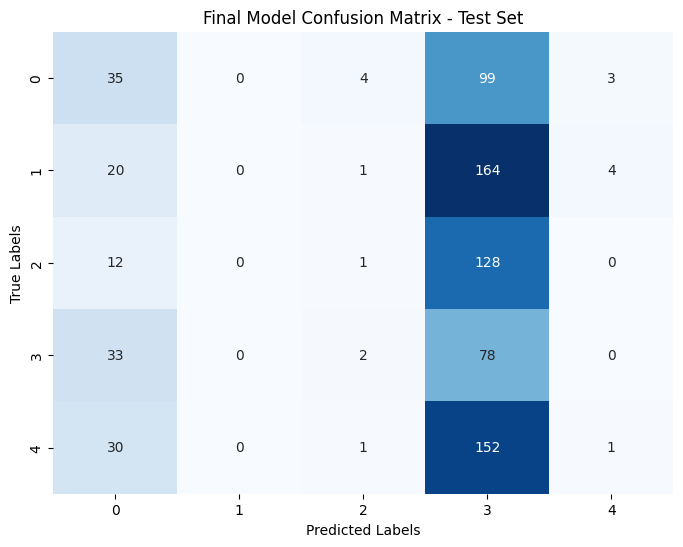

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


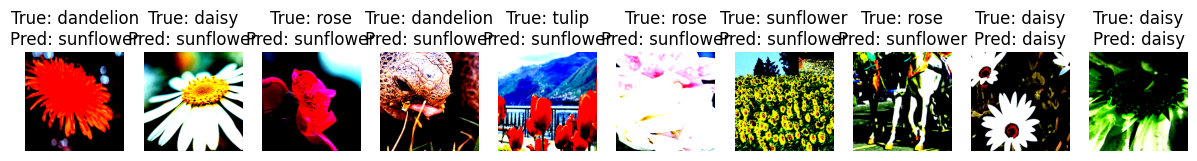

In [ ]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Define the loss function and optimizer for testing
final_criterion = nn.CrossEntropyLoss()

# Evaluate the final model on the test set
final_model.eval()
test_correct = 0
test_total = 0
test_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = final_model(images)
        _, predicted = torch.max(outputs, 1)
        test_predictions.extend(predicted.tolist())

        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

final_test_accuracy = test_correct / test_total
print(f"Final Model Test Accuracy: {final_test_accuracy}")

# Calculate additional evaluation metrics
final_accuracy, final_precision, final_recall, final_f1, final_confusion_mat = evaluate_model(final_model, test_loader)

print(f"Final Model Test Accuracy: {final_accuracy}")
print(f"Final Model Test Precision: {final_precision}")
print(f"Final Model Test Recall: {final_recall}")
print(f"Final Model Test F1-score: {final_f1}")
print("Final Model Confusion Matrix:")
print(final_confusion_mat)

# Visualize the confusion matrix for the final model
plt.figure(figsize=(8, 6))
sns.heatmap(final_confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Final Model Confusion Matrix - Test Set')
plt.show()

# Visualize predictions and misclassifications for the final model on the test set
visualize_predictions(final_model, test_loader)
